In [20]:
import numpy as np
import pandas as pd

In [21]:
# Load the dataset
path = "motor_data11-14lats.csv"
df = pd.read_csv(path)

In [22]:
df.head()


,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID
0,0,08-AUG-13,07-AUG-14,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
1,0,08-AUG-12,07-AUG-13,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
2,0,08-AUG-11,07-AUG-12,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
3,0,08-JUL-11,07-AUG-11,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN
4,0,08-AUG-13,07-AUG-14,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43


In [23]:
# - Strip leading/trailing spaces
# - Make all uppercase
# - Replace spaces with underscores (safer for coding)
df.columns = [c.strip().upper().replace(" ", "_") for c in df.columns]

print(df.columns.tolist())

['SEX', 'INSR_BEGIN', 'INSR_END', 'EFFECTIVE_YR', 'INSR_TYPE', 'INSURED_VALUE', 'PREMIUM', 'OBJECT_ID', 'PROD_YEAR', 'SEATS_NUM', 'CARRYING_CAPACITY', 'TYPE_VEHICLE', 'CCM_TON', 'MAKE', 'USAGE', 'CLAIM_PAID']


In [24]:
# Convert to datetime so we can engineer features later (year/month/duration)
for col in ["INSR_BEGIN", "INSR_END"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

/tmp/ipython-input-3021891791.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/tmp/ipython-input-3021891791.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


In [25]:
# 4) Convert numeric columns safely
numeric_cols = [
    "PREMIUM", "INSURED_VALUE", "SEATS_NUM", "CARRYING_CAPACITY",
    "CCM_TON", "PROD_YEAR", "EFFECTIVE_YR", "CLAIM_PAID"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


In [26]:
# 5) Remove unusable rows for modelling
# PREMIUM is our target, so we must drop missing target rows.
df = df.dropna(subset=["PREMIUM"])

# Remove negative/zero premium values (not realistic for this context)
df = df[df["PREMIUM"] > 0]

print("Shape after removing missing/invalid PREMIUM:", df.shape)

Shape after removing missing/invalid PREMIUM: (293509, 16)


In [27]:
# 6) Basic missing-value report (helps your methodology section)
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_report = missing_rate[missing_rate > 0].to_frame("missing_rate")
display(missing_report)


,missing_rate
CLAIM_PAID,0.923777
CARRYING_CAPACITY,0.277198
EFFECTIVE_YR,0.000920
SEATS_NUM,0.000477
PROD_YEAR,0.000361
CCM_TON,0.000007


In [28]:
# Policy duration in days
if "INSR_BEGIN" in df.columns and "INSR_END" in df.columns:
    df["POLICY_DURATION_DAYS"] = (df["INSR_END"] - df["INSR_BEGIN"]).dt.days

    # Remove impossible durations (negative or extremely long)
    df.loc[(df["POLICY_DURATION_DAYS"] < 0) | (df["POLICY_DURATION_DAYS"] > 3660), "POLICY_DURATION_DAYS"] = np.nan

# Extract time features from INSR_BEGIN
if "INSR_BEGIN" in df.columns:
    df["BEGIN_YEAR"] = df["INSR_BEGIN"].dt.year
    df["BEGIN_MONTH"] = df["INSR_BEGIN"].dt.month

# Vehicle age (if production year exists)
if "PROD_YEAR" in df.columns and "INSR_BEGIN" in df.columns:
    df["VEHICLE_AGE"] = df["BEGIN_YEAR"] - df["PROD_YEAR"]

    # Remove unrealistic vehicle ages (negative or very high)
    df.loc[(df["VEHICLE_AGE"] < 0) | (df["VEHICLE_AGE"] > 50), "VEHICLE_AGE"] = np.nan



In [29]:
df.head()  # After Cleaning

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,POLICY_DURATION_DAYS,BEGIN_YEAR,BEGIN_MONTH,VEHICLE_AGE
0,0,2013-08-08,2014-08-07,8.0,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN,364.0,2013,8,6.0
1,0,2012-08-08,2013-08-07,8.0,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN,364.0,2012,8,5.0
2,0,2011-08-08,2012-08-07,8.0,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN,365.0,2011,8,4.0
3,0,2011-07-08,2011-08-07,8.0,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,NaN,30.0,2011,7,4.0
4,0,2013-08-08,2014-08-07,8.0,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43,364.0,2013,8,3.0


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:

df.columns = [c.strip().upper() for c in df.columns]
df["PREMIUM"] = pd.to_numeric(df["PREMIUM"], errors="coerce")
df = df.dropna(subset=["PREMIUM"])
df = df[df["PREMIUM"] > 0]

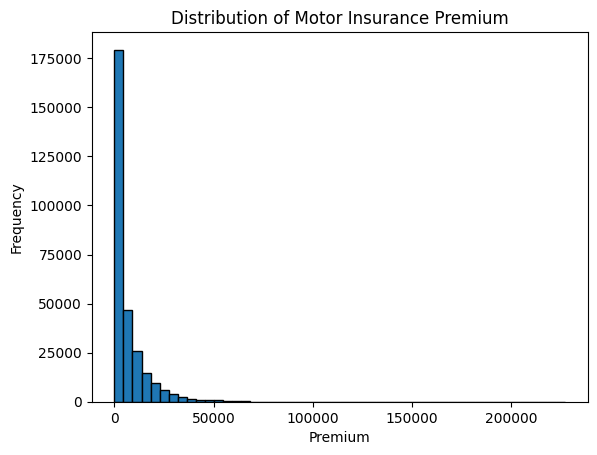

In [32]:
plt.figure()
plt.hist(df["PREMIUM"], bins=50, edgecolor='black')
plt.title("Distribution of Motor Insurance Premium")
plt.xlabel("Premium")
plt.ylabel("Frequency")
plt.show()

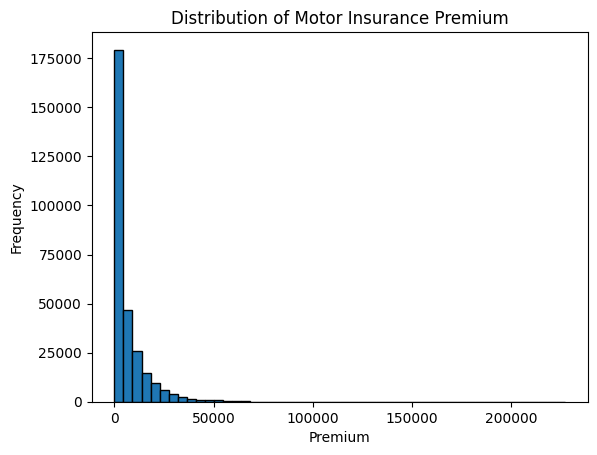

In [33]:
plt.figure()
plt.hist(df["PREMIUM"], bins=50,edgecolor='black')
plt.title("Distribution of Motor Insurance Premium")
plt.xlabel("Premium")
plt.ylabel("Frequency")
plt.show()

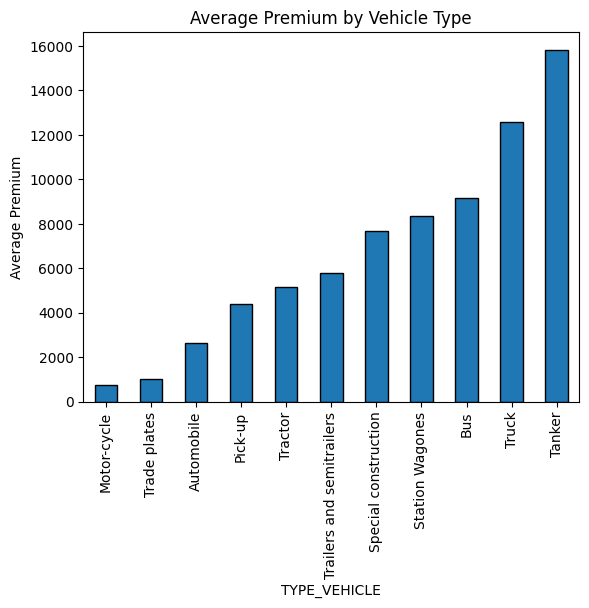

In [34]:
if "TYPE_VEHICLE" in df.columns:
    avg_premium = df.groupby("TYPE_VEHICLE")["PREMIUM"].mean().sort_values()

    plt.figure()
    avg_premium.plot(kind="bar",edgecolor='black')
    plt.title("Average Premium by Vehicle Type")
    plt.ylabel("Average Premium")
    plt.show()

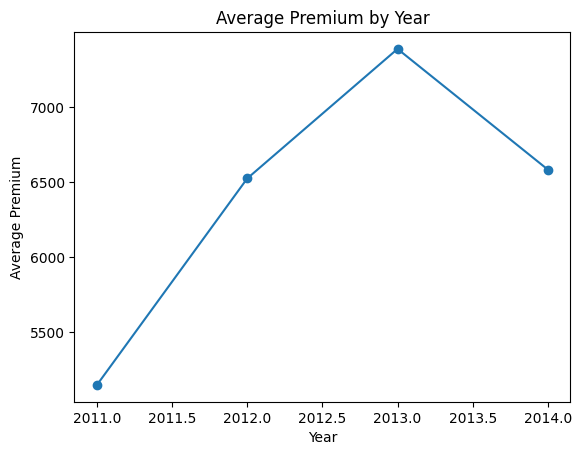

In [35]:
if "INSR_BEGIN" in df.columns:
    df["INSR_BEGIN"] = pd.to_datetime(df["INSR_BEGIN"], errors="coerce")
    df["YEAR"] = df["INSR_BEGIN"].dt.year

    yearly_avg = df.groupby("YEAR")["PREMIUM"].mean()

    plt.figure()
    yearly_avg.plot(marker='o')
    plt.title("Average Premium by Year")
    plt.ylabel("Average Premium")
    plt.xlabel("Year")
    plt.show()

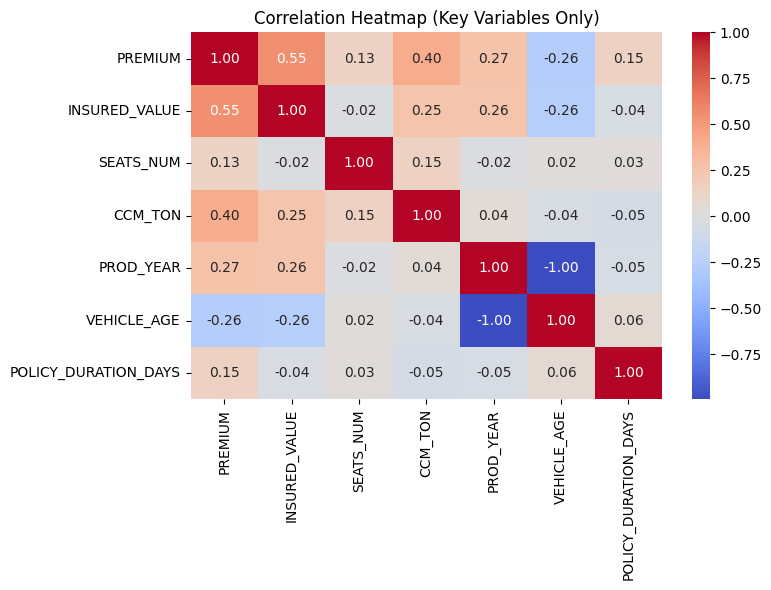

In [37]:
import seaborn as sns

important_cols = [
    "PREMIUM",
    "INSURED_VALUE",
    "SEATS_NUM",
    "CCM_TON",
    "PROD_YEAR",
    "VEHICLE_AGE",
    "POLICY_DURATION_DAYS"
]

important_cols = [c for c in important_cols if c in df.columns]

corr_matrix = df[important_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Heatmap (Key Variables Only)")
plt.tight_layout()
plt.show()